## Violent Crime (by county) rate predictions

In [5]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

#### Joseph O'Malley

Notebook 3: GLM modeling and Regularization 

#### Load in Crime dataset
Using the dataset in UCO called Crimes and Communities (https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime - it has 128 variables and 1994 rows. Read this file in DIRECTLY from the URL address. Cal is Crime. 

In [1]:
## load in headers data and display data frame

# import module(s) into namespace
import pandas as pd #we almost always need pandas because we like data frames
import numpy as np
pd.set_option('display.max_colwidth', 150) #important for getting all the text

##load in names
c=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.names'
              ,header=None, sep = "::")
## check shape of data imported
c.shape


/Users/ultrajosef/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


(485, 1)

In [2]:
## check datatypes
c.dtypes

0    object
dtype: object

In [3]:
## create second column to detect presence of "@attribute"
c.loc[c[0].str.contains('@attribute'), 'Activity_2'] = 1

## subset to include only columns that had an "@attribute" in them
c = c.loc[c['Activity_2'] == 1.0]
c.shape

## custom replace metadata elements
c[0] = c[0].replace({'@attribute':'', 'numeric':'', 'string':''}, regex=True)
c.head(20)

## remove attribute column, keep only names
c = c[0]
c.head()

57             state 
58            county 
59         community 
60     communityname 
61              fold 
Name: 0, dtype: object

In [4]:
## load in body of data and use new transformed headers in argument
url="https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data"
c=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/communities/communities.data",
              names = c, sep = ",")
## replace
c = c.replace({'?':0})
c.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop
0,8,0,0,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20
1,53,0,0,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.02,0.12,0.45,0,0,0,0,0.00,0,0.67
2,24,0,0,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.01,0.21,0.02,0,0,0,0,0.00,0,0.43
3,34,5,81440,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.02,0.39,0.28,0,0,0,0,0.00,0,0.12
4,42,95,6096,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.04,0.09,0.02,0,0,0,0,0.00,0,0.03


In [5]:
### Replace nulls with median
c.fillna((c.median()), inplace=True)

In [6]:
## check distribution of numeric columns
c.describe()

,state,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,...,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000,1994.000000
mean,28.683551,5.493982,0.057593,0.463395,0.179629,0.753716,0.153681,0.144022,0.424218,0.493867,...,0.215552,0.608892,0.535050,0.626424,0.651530,0.065231,0.232854,0.161685,0.094052,0.237979
std,16.397553,2.873694,0.126906,0.163717,0.253442,0.244039,0.208877,0.232492,0.155196,0.143564,...,0.231134,0.204329,0.181352,0.200521,0.198221,0.109459,0.203092,0.229055,0.240328,0.232985
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12.000000,3.000000,0.010000,0.350000,0.020000,0.630000,0.040000,0.010000,0.340000,0.410000,...,0.060000,0.470000,0.420000,0.520000,0.560000,0.020000,0.100000,0.020000,0.000000,0.070000
50%,34.000000,5.000000,0.020000,0.440000,0.060000,0.850000,0.070000,0.040000,0.400000,0.480000,...,0.130000,0.630000,0.540000,0.670000,0.700000,0.040000,0.170000,0.070000,0.000000,0.150000
75%,42.000000,8.000000,0.050000,0.540000,0.230000,0.940000,0.170000,0.160000,0.470000,0.540000,...,0.280000,0.777500,0.660000,0.770000,0.790000,0.070000,0.280000,0.190000,0.000000,0.330000
max,56.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# move the column to head of list using index, pop and insert
cols = list(c)
cols.insert(0, cols.pop(cols.index(' ViolentCrimesPerPop ')))
cols

[' ViolentCrimesPerPop ',
 ' state ',
 ' county ',
 ' community ',
 ' communityname ',
 ' fold ',
 ' population ',
 ' householdsize ',
 ' racepctblack ',
 ' racePctWhite ',
 ' racePctAsian ',
 ' racePctHisp ',
 ' agePct12t21 ',
 ' agePct12t29 ',
 ' agePct16t24 ',
 ' agePct65up ',
 ' numbUrban ',
 ' pctUrban ',
 ' medIncome ',
 ' pctWWage ',
 ' pctWFarmSelf ',
 ' pctWInvInc ',
 ' pctWSocSec ',
 ' pctWPubAsst ',
 ' pctWRetire ',
 ' medFamInc ',
 ' perCapInc ',
 ' whitePerCap ',
 ' blackPerCap ',
 ' indianPerCap ',
 ' AsianPerCap ',
 ' OtherPerCap ',
 ' HispPerCap ',
 ' NumUnderPov ',
 ' PctPopUnderPov ',
 ' PctLess9thGrade ',
 ' PctNotHSGrad ',
 ' PctBSorMore ',
 ' PctUnemployed ',
 ' PctEmploy ',
 ' PctEmplManu ',
 ' PctEmplProfServ ',
 ' PctOccupManu ',
 ' PctOccupMgmtProf ',
 ' MalePctDivorce ',
 ' MalePctNevMarr ',
 ' FemalePctDiv ',
 ' TotalPctDiv ',
 ' PersPerFam ',
 ' PctFam2Par ',
 ' PctKids2Par ',
 ' PctYoungKids2Par ',
 ' PctTeen2Par ',
 ' PctWorkMomYoungKids ',
 ' PctWorkMom '

In [8]:
# use ix to reorder
c = c.loc[:, cols]

# drop 
c=c.drop([' communityname '], axis=1)
c.head()

,ViolentCrimesPerPop,state,county,community,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,PolicAveOTWorked,LandArea,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop
0,0.20,8,0,0,1,0.19,0.33,0.02,0.90,0.12,...,0.29,0.12,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14
1,0.67,53,0,0,1,0.00,0.16,0.12,0.74,0.45,...,0,0.02,0.12,0.45,0,0,0,0,0.00,0
2,0.43,24,0,0,1,0.00,0.42,0.49,0.56,0.17,...,0,0.01,0.21,0.02,0,0,0,0,0.00,0
3,0.12,34,5,81440,1,0.04,0.77,1.00,0.08,0.12,...,0,0.02,0.39,0.28,0,0,0,0,0.00,0
4,0.03,42,95,6096,1,0.01,0.55,0.02,0.95,0.09,...,0,0.04,0.09,0.02,0,0,0,0,0.00,0


### Create Test/Train Split of data

In [9]:
from sklearn.model_selection import train_test_split

# split dataset into testing and training (70/30)
features_train, features_test, target_train, target_test = train_test_split(
    c.iloc[:,1:].values, c.iloc[:,0].values, test_size=0.30, random_state=0)

In [10]:
print(features_test.shape)
print(features_train.shape)
print(target_test.shape)
print(target_train.shape)

(599, 126)
(1395, 126)
(599,)
(1395,)


### Model 1 - LASSO Regression

In [11]:
# Lasso Regression
# fit a LASSO model to the data
from sklearn.linear_model import Lasso
model = Lasso(alpha=0.1, random_state=33)
model.fit(features_train, target_train)
print(model)
# make predictions
expected = target_test
predicted = model.predict(features_test)
# summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print("mse" ,mse)
print("R-squared" ,model.score(features_test, target_test))

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=33,
   selection='cyclic', tol=0.0001, warm_start=False)
AUC 0.04889288496714473
R-squared 0.08875018915026245


In [7]:
#Show importance of each feature in Random Forest
zip(c_reg.columns[1:20], model.feature_importances_)

NameError: name 'c_reg' is not defined

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

expected = target_test
predicted = model.predict(features_test)

## create threshold (median) for testing accuracy of classification
expected = np.where(expected > c.iloc[:,0].values.mean(), 1, 0)
predicted = np.where(predicted > c.iloc[:,0].values.mean(), 1, 0)

## output predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(expected, predicted)
print("AUC:" ,auc(false_positive_rate, true_positive_rate))
print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))

AUC: 0.6048965782946856
             precision    recall  f1-score   support

          0       0.73      0.57      0.64       381
          1       0.46      0.64      0.53       218

avg / total       0.63      0.60      0.60       599

[[218 163]
 [ 79 139]]


#### visualize correlation matrix

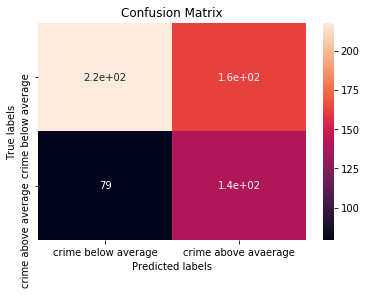

In [13]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt     

## define confusion matrix
cm = confusion_matrix(expected, predicted)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['crime below average', 'crime above avaerage']); ax.yaxis.set_ticklabels(['crime below average', 'crime above average']);


In [14]:
## create Grid Search to optimize tuning parameters
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
import time

# use a full grid over all parameters
param_grid = {"alpha": [.001, .1, 1, 10, 100]}
start_time = time.clock()

# run grid search
grid_search = GridSearchCV(model, param_grid=param_grid,n_jobs=-1)
grid_search.fit(features_train, target_train)


#print(grid_search.cv_results_)
#print("SCORES", grid_search.cv_results_)
print("BEST SCORE", grid_search.best_score_)
print("BEST PARAM", grid_search.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

BEST SCORE 0.6508178764088925
BEST PARAM {'alpha': 0.001}
Time to run 0.302797 seconds


#### LASSO Performance:
The baseline performed very poorly with an R^2 of just 0.089 and an accuracy of ~63% (above a 50% a priori on classification). 
#### Grid Search:
I used a grid search in this model, which evaluates each combination of parameters and chooses the best.  In this case, it found the best value for "alpha" (to .001). Changing this parameter improved the model R^2 by .562 (to .651) over the default parameters (aplha=0.1).  This change is alarming, as is an alpha of .001, which is less linear, therefore at an increased risk of overfitting and may not generalize as well to new data.

### Model 2 - Ridge Regression

In [15]:
# Ridge Regression
import numpy as np
from sklearn import datasets
from sklearn.linear_model import Ridge

# fit a ridge regression model to the data
model = Ridge(alpha=0.1, random_state=33)
model.fit(features_train, target_train)
print(model)
# make predictions
expected = target_test
predicted = model.predict(features_test)
# summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print("MSE" ,mse)
print("R-squared" ,model.score(features_test, target_test))

Ridge(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=33, solver='auto', tol=0.001)
MSE 0.019146148436197198
R-squared 0.6431602644697738


In [16]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score

expected = target_test
predicted = model.predict(features_test)

## check mean rate of violent crime
print("Average Rate of Violent Crime:" ,c.iloc[:,0].values.mean())

## create threshold (mean) for testing accuracy of classification
expected = np.where(expected > c.iloc[:,0].values.mean(), 1, 0)
predicted = np.where(predicted > c.iloc[:,0].values.mean(), 1, 0)

## output predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(expected, predicted)
print("AUC:" ,auc(false_positive_rate, true_positive_rate))
print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))

Average Rate of Violent Crime: 0.2379789368104313
AUC: 0.8396843169833129
             precision    recall  f1-score   support

          0       0.89      0.86      0.88       381
          1       0.77      0.82      0.79       218

avg / total       0.85      0.84      0.85       599

[[327  54]
 [ 39 179]]


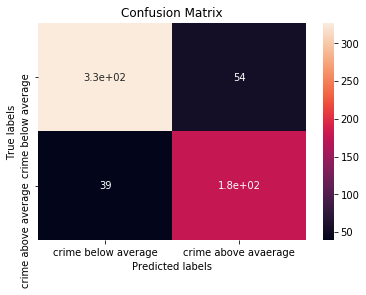

In [17]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt     

## define confusion matrix
cm = confusion_matrix(expected, predicted)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['crime below average', 'crime above avaerage']); ax.yaxis.set_ticklabels(['crime below average', 'crime above average']);

In [18]:
## create Grid Search to optimize tuning parameters
# use a full grid over all parameters
param_grid = {"alpha": [.001, .1, 1, 10, 100]}
start_time = time.clock()


# run grid search
grid_search = GridSearchCV(model, param_grid=param_grid,n_jobs=-1, cv=5)
grid_search.fit(features_train, target_train)


#print(grid_search.cv_results_)
#print("SCORES", grid_search.cv_results_)
print("BEST SCORE", grid_search.best_score_)
print("BEST PARAM", grid_search.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

BEST SCORE 0.6647430557185637
BEST PARAM {'alpha': 1}
Time to run 0.3371529999999998 seconds


#### Ridge Regression Performance:
The baseline performed fairly well with an R^2 of 0.643, Accuracy of ~85% (on classification). 
#### Grid Search:
I used a grid search in this model, which evaluates each combination of parameters and chooses the best.  In this case, it found the best value for "alpha" (1, with a higher alpha leading to a more linear model that is at less risk of overfitting).  Changing this parameter improved the model R^2 by .022 (to .665) over the default parameters (aplha=0.1).
#### Cross Validation:
Additionally, I added Cross Validation which takes the average 5 subsets (k-folds) used to create a more generalizable model and improve performance.  It does this by holding out a different sample each time and using the remaining data to train on.  This allows the use of all the data in the training of the model.

### Model 3 - ElasticNet Regression

In [19]:
# ElasticNet Regression
# fit a model to the data
from sklearn.linear_model import ElasticNet
model = ElasticNet(alpha=0.1, random_state=33)
model.fit(features_train, target_train)
print(model)
# make predictions
expected = target_test
predicted = model.predict(features_test)
# summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print(mse)
print(model.score(features_test, target_test))

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=33, selection='cyclic', tol=0.0001, warm_start=False)
0.048936888690755694
0.08793006195089348


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
#Notice I did not load my Datamining packages yet (ie decision tree). I will do that as I use them.

expected = target_test
predicted = model.predict(features_test)

## create threshold (mean) for testing accuracy of classification
expected = np.where(expected > c.iloc[:,0].values.mean(), 1, 0)
predicted = np.where(predicted > c.iloc[:,0].values.mean(), 1, 0)

## output predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(expected, predicted)
print("DT Accuracy Score", accuracy_score(expected, predicted))
print("AUC:" ,auc(false_positive_rate, true_positive_rate))
print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))

DT Accuracy Score 0.5976627712854758
AUC: 0.6062089142526907
             precision    recall  f1-score   support

          0       0.73      0.57      0.65       381
          1       0.46      0.64      0.54       218

avg / total       0.64      0.60      0.61       599

[[219 162]
 [ 79 139]]


In [21]:
## create Grid Search to optimize tuning parameters
# use a full grid over all parameters
param_grid = {"alpha": [.001, .1, 1, 10, 100]}
start_time = time.clock()


# run grid search
grid_search = GridSearchCV(model, param_grid=param_grid,n_jobs=-1, cv=5)
grid_search.fit(features_train, target_train)


#print(grid_search.cv_results_)
#print("SCORES", grid_search.cv_results_)
print("BEST SCORE", grid_search.best_score_)
print("BEST PARAM", grid_search.best_params_)
print("Time to run", time.clock() - start_time, "seconds")

BEST SCORE 0.6597001651100803
BEST PARAM {'alpha': 0.001}
Time to run 0.4842240000000002 seconds


#### Elastic Net Performance:
The baseline performed very poorly with an R^2 of just 0.089 and an AUC of 0.61 (on classification). 
#### w/Grid Search:
I used a grid search in this model, which evaluates each combination of parameters and chooses the best.  In this case, it found the best value for "alpha" (.001, with a higher alpha leading to a more linear model that is at less risk of overfitting).  Changing this parameter improved the model R^2 by .572 (to 0.66) over the default parameters (aplha=0.1). This change is alarming, as is an alpha of .001, which is at an increased risk of overfitting and may not generalize as well to new data.  

#### w/Cross Validation:
Additionally, I added Cross Validation which takes the average 5 subsets (k-folds) used to create a more generalizable model and improve performance.  It does this by holding out a different sample each time and using the remaining data to train on.  This allows the use of all the data in the training of the model.

### Model 4 - OLS regression

In [22]:
from sklearn import linear_model

model = linear_model.LinearRegression()

model.fit(features_train, target_train)
print(model)
# make predictions
expected = target_test
predicted = model.predict(features_test)
# summarize the fit of the model
mse = np.mean((predicted-expected)**2)
print("MSE" ,mse)
print("R-squared" ,model.score(features_test, target_test))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
MSE 0.019279524130706372
R-squared 0.6406744513197601


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, roc_auc_score
#Notice I did not load my Datamining packages yet (ie decision tree). I will do that as I use them.

expected = target_test
predicted = model.predict(features_test)

## create threshold (mean) for testing accuracy of classification
expected = np.where(expected > c.iloc[:,0].values.mean(), 1, 0)
predicted = np.where(predicted > c.iloc[:,0].values.mean(), 1, 0)

## output predictions
false_positive_rate, true_positive_rate, thresholds = roc_curve(expected, predicted)
print("AUC:" ,auc(false_positive_rate, true_positive_rate))
print(classification_report(expected, predicted))
print(confusion_matrix(expected, predicted))

AUC: 0.8311601531459943
             precision    recall  f1-score   support

          0       0.89      0.85      0.87       381
          1       0.76      0.81      0.78       218

avg / total       0.84      0.84      0.84       599

[[324  57]
 [ 41 177]]


#### OLS Performance:
The simple OLS regression model performed relatively well (R^2 of .641, AUC of 0.83, and accuracy of 84%) with no adjustments.  It serves as a good baseline for regression model performance.

### Conclusion:

The best performing model was the Ridge Regression with an alpha of 1 and k=5 fold Cross Validation.  The models R^2 was 0.665, which means that just over 2/3rds of the variance was explained.  Using the OLS regression as a baseline (R^2 = .641), this is an improvement of 0.024 (or 2.4%).  

## END